# 5NN CODE

#### Aim: For every galaxy in the catalog, find its 5th nearest projected neighbor within some velocity/redshift range of that galaxy.

#### Notes
- kNN --> average projected density from kth nearest neighbor (number galaxies per Mpc^2)

- redshift slice for each galaxy can be physically motivated at the outset!

- what is biggest velocity dispersion we could expect? Coma velocity dispersion ~1100 km/s. use ~2000 km/s for 2-sigma?

- ACTUALLY. for now, +/- 500 km/s.

5NN projected distance is a biased indicator based on density. Clusters very dense, but if we reduce redshift slice too much we remove nearby galaxies with massive velocity dispersions. In less dense environments, a small redshift would be helpful - too large and we include galaxies that are not, in fact, nearby.

#### 5 Nearest Neighbor Density Equation:

$\Sigma_{5\text{NN}} = \frac{5}{\pi r_5^2}$

- units: Mpc$^{-2}$

- $r_5$ = distance to 5th nearest neighbor

### Running k=5, k=3

In [1295]:
%run kNN_local_density.py -vr_limit 500 -k 3 

-vr_limit [int in km/s; default is 500] -radius_limit [int in Mpc; default is 100 (no radius bounds)] -k [int; default is 5 (for fifth nearest neighbor)] -vfs [if included, will use VFS catalog and SGY bounds (from Castignani+22) in place of the vr_limit slice; otherwise, will default to WISESize catalog]
Using vr_limit = 500 km/s
Using radius_limit = 100 Mpc --> no limit!
Using k = 3
Number of Galaxies without kSigma: 1500
Execution Time: 1.2e+01 minute(s)


<Figure size 640x480 with 0 Axes>

In [ ]:
all_3NN = all_kNN

-vr_limit [int in km/s; default is 500] -radius_limit [int in Mpc; default is 100 (no radius bounds)] -k [int; default is 5 (for fifth nearest neighbor)] -vfs [if included, will use VFS catalog and SGY bounds (from Castignani+22) in place of the vr_limit slice; otherwise, will default to NED-LVS catalog] -write [will write array output to nedlvs_parent table]
Using vr_limit = 600 km/s
Using radius_limit = 100 Mpc --> no limit!
Using k = 5
Applying mass completeness limit flag to catalog...
Applying sSFR limit flag to catalog...
No sSFR limit flag found! Ignoring.
Applying SFR limit flag to catalog...
No SFR limit flag found! Ignoring.
Removing objects with negative redshifts...
Number of objects with negative redshift: 0
Diagnostic plot saved to: /Users/k215c316/Desktop/redshift_SG.png
# galaxies in input table without kSigma: 4457
2D_5NN column added to (or updated in) /Users/k215c316/Desktop/wisesize/nedlvs_parent_v1.fits
Execution Time: 4.9 minute(s)


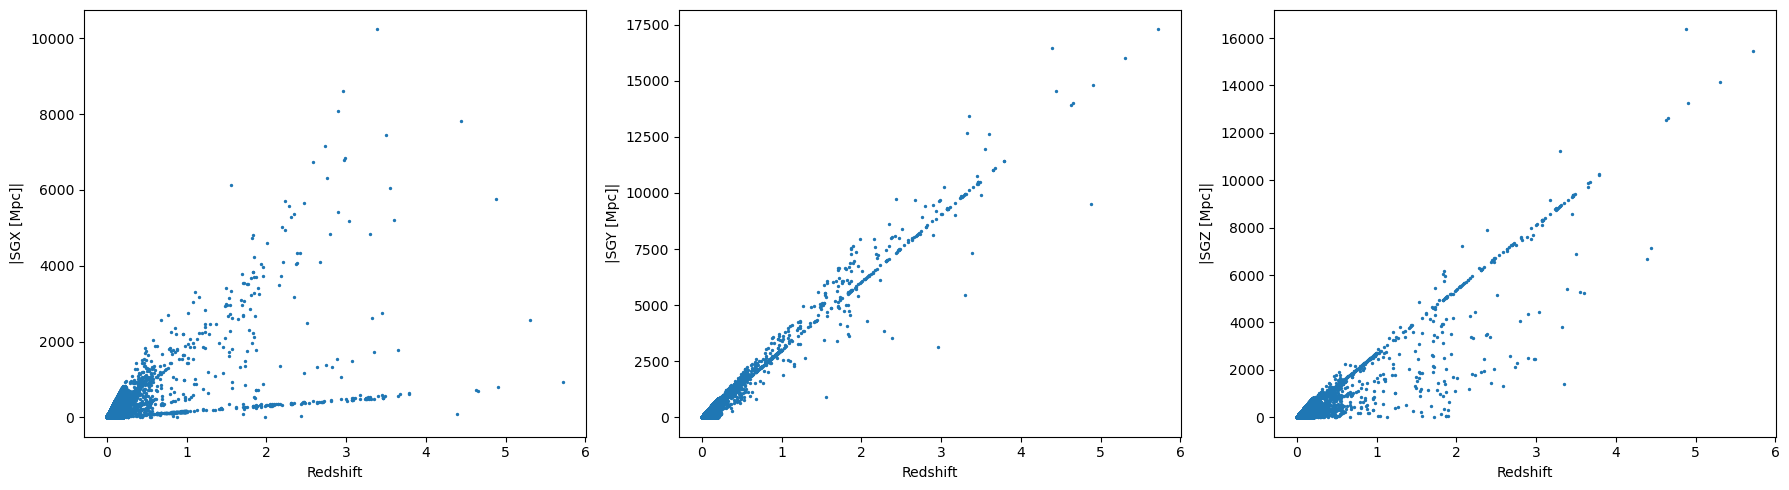

<Figure size 640x480 with 0 Axes>

In [49]:
%run kNN_local_density.py -vr_limit 600 -k 5 -write

In [50]:
all_5NN = all_kNN

In [1299]:
#plot_kNN(k,ra,dec,all_kNN)

### Manually saving $\Sigma_5$ to Table

In [ ]:
#NOTE: all_5NN may not be fully row-matched to parent table due to mass, SFR, sSFR limits
#we shall check.

#read parent catalog
from astroy.table import Table
import os
homedir=os.getenv("HOME")
cat=Table.read(homedir+'/Desktop/wisesize/nedlvs_parent_v1.fits')

mstarflag = cat['Mstar_flag']
sfrflag = cat['SFR_flag']
ssfrflag = cat['sSFR_flag']

#these are ALL flags applied to the 5NN input table
flags = (mstarflag) & (sfrflag) & (ssfrflag)

all_5NN_parent = np.full(len(cat), -999)
all_5NN_parent[flags] = all_5NN

In [ ]:
cat['2D_5NN'] = all_5NN_parent

In [1350]:
cat.write(homedir+'/Desktop/wisesize/nedlvs_parent_v1.fits',overwrite=True)

### Creating k=5 2D projected surface density slices

In [52]:
wisesize_flag = cat['WISESize_flag']

all_RA = cat['RA'][(wisesize_flag) & (~np.isnan(all_5NN)) & (all_5NN>0)]
all_DEC = cat['DEC'][(wisesize_flag) & (~np.isnan(all_5NN)) & (all_5NN>0)]
all_5NN = all_5NN[(wisesize_flag) & (~np.isnan(all_5NN)) & (all_5NN>0)]

In [53]:
low5NN=np.log10(np.min(all_5NN))
high5NN=np.log10(np.max(all_5NN))
sorted_5NN = np.sort(all_5NN)
first_33percent_index = int(0.33*len(all_RA))
third_66percent_index = int(0.66*len(all_RA))
bin1bound = np.log10(sorted_5NN[first_33percent_index])
bin2bound = np.log10(sorted_5NN[third_66percent_index])

#first bin is lowz to bin1bound
#second bin is bin1bound to bin2bound
#third bin is bin2bound to highz

bin1flag = (np.log10(all_5NN)>low5NN) & (np.log10(all_5NN)<bin1bound)
bin2flag = (np.log10(all_5NN)>bin1bound) & (np.log10(all_5NN)<bin2bound)
bin3flag = (np.log10(all_5NN)>bin2bound) & (np.log10(all_5NN)<high5NN)

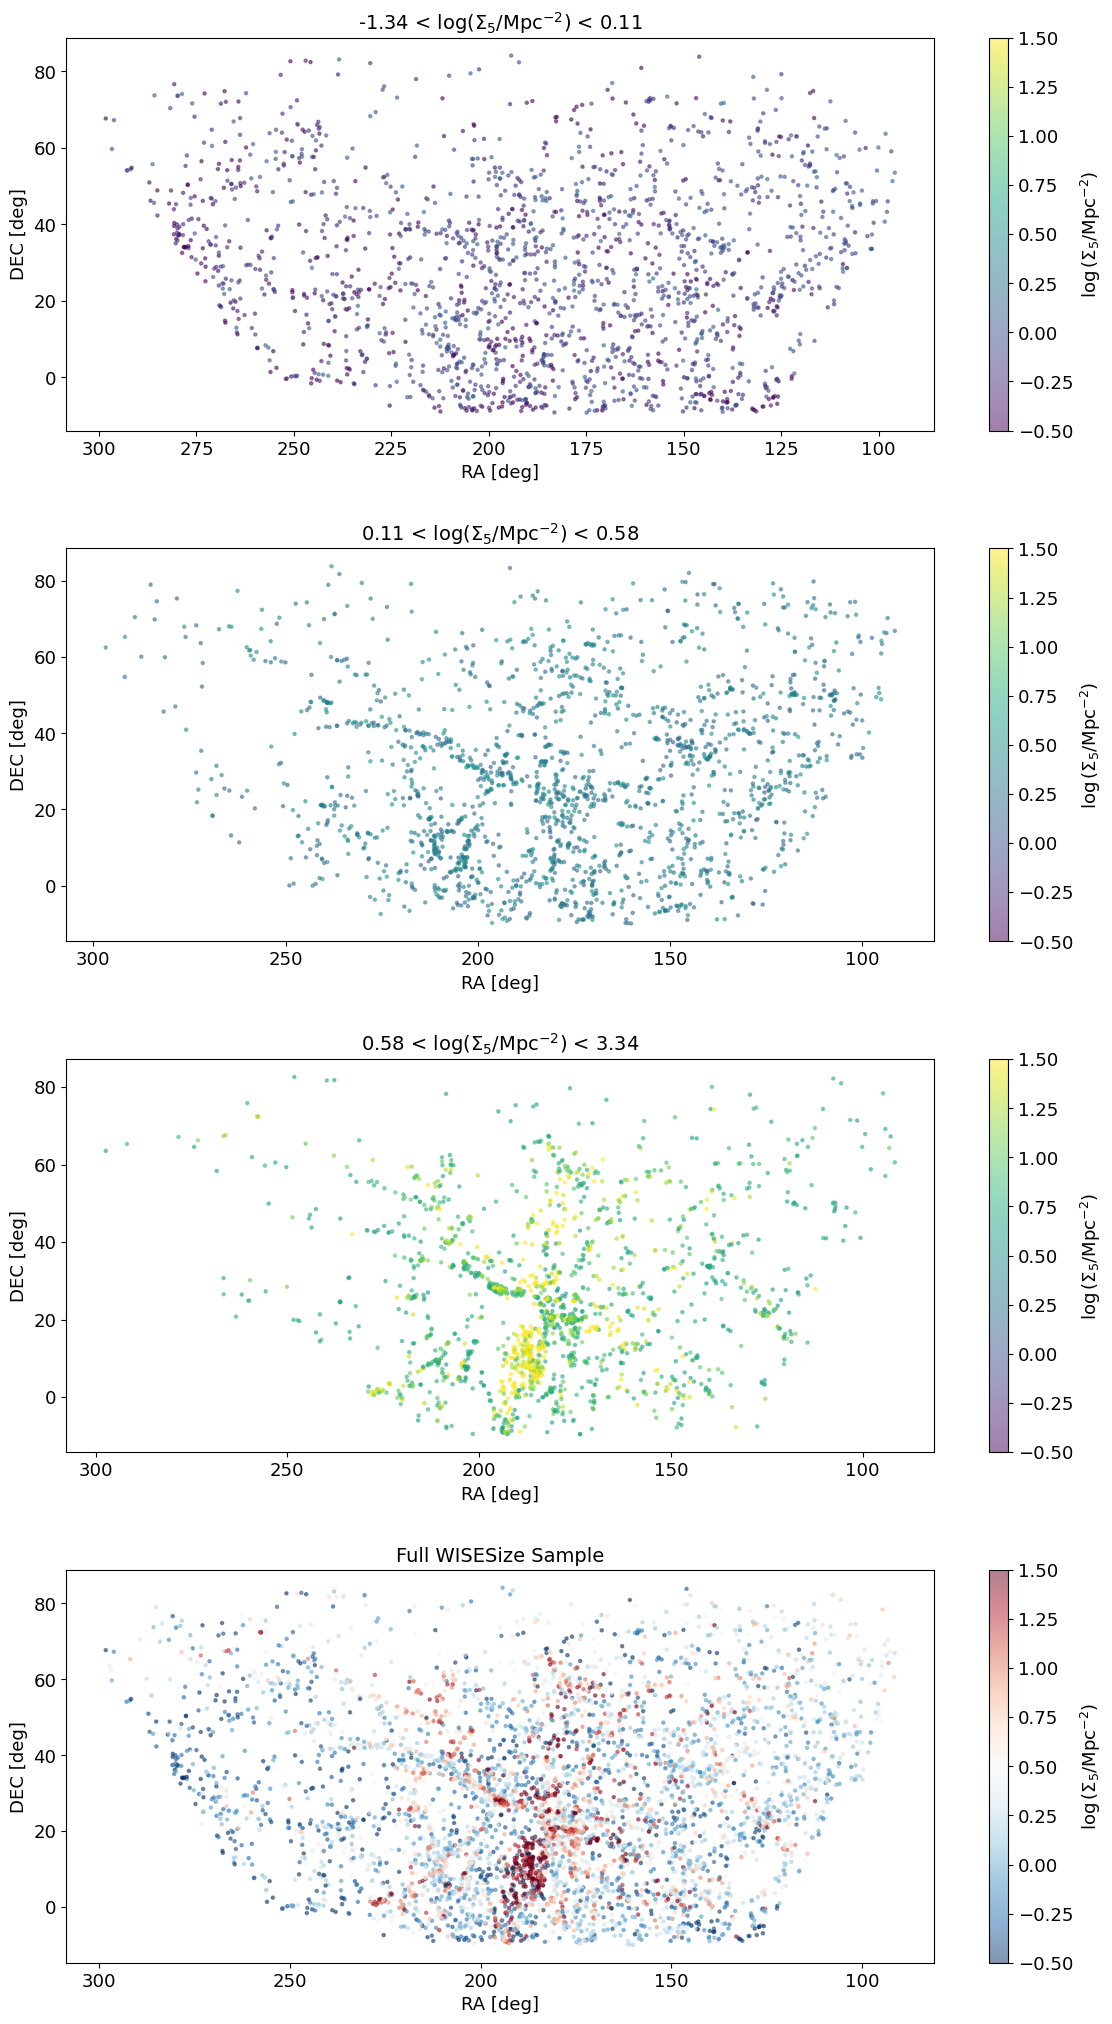

In [54]:
#define "good" flag, which filters out all instances where galaxies did not have a kNN
#given our isolation constraints
good_flag = (all_5NN!=-999) & (~np.isnan(all_5NN))

fig = plt.figure(figsize=(14,25))
ax = fig.add_subplot(4,1,1)
plt.subplots_adjust(hspace=0.3)

im = ax.scatter(all_RA[good_flag & bin1flag], all_DEC[good_flag & bin1flag],
                c=np.log10(all_5NN[good_flag & bin1flag]), cmap='viridis', alpha=0.5, s=5, vmin=-0.5, vmax=1.5)
ax.invert_xaxis()
ax.set_xlabel('RA [deg]',fontsize=13)
ax.set_ylabel('DEC [deg]',fontsize=13)
ax.set_title(fr'{low5NN:.2f} < ' + r'log$(\Sigma_5$/Mpc$^{-2}$) < '+ \
              f'{bin1bound:.2f}', fontsize=14)

ax.tick_params(labelsize=13)

cb = fig.colorbar(im)
cb.ax.tick_params(labelsize=13)
cb.set_label(fr'$\log$($\Sigma_{5}$/'+r'Mpc$^{-2}$)',fontsize=13)

ax2 = fig.add_subplot(4,1,2)

im2 = ax2.scatter(all_RA[good_flag & bin2flag], all_DEC[good_flag & bin2flag],
                c=np.log10(all_5NN[good_flag & bin2flag]), cmap='viridis', alpha=0.5, s=5, vmin=-0.5, vmax=1.5)
ax2.invert_xaxis()
ax2.set_xlabel('RA [deg]',fontsize=13)
ax2.set_ylabel('DEC [deg]',fontsize=13)
ax2.set_title(fr'{bin1bound:.2f} < ' + r'log$(\Sigma_5$/Mpc$^{-2}$) < '+ \
              f'{bin2bound:.2f}', fontsize=14)

ax2.tick_params(labelsize=13)

cb2 = fig.colorbar(im2)
cb2.ax.tick_params(labelsize=13)
cb2.set_label(fr'$\log$($\Sigma_{5}$/'+r'Mpc$^{-2}$)',fontsize=13)


ax3 = fig.add_subplot(4,1,3)

im3 = ax3.scatter(all_RA[good_flag & bin3flag], all_DEC[good_flag & bin3flag],
                c=np.log10(all_5NN[good_flag & bin3flag]), cmap='viridis', alpha=0.5, s=5, vmin=-0.5, vmax=1.5)
ax3.invert_xaxis()
ax3.set_xlabel('RA [deg]',fontsize=13)
ax3.set_ylabel('DEC [deg]',fontsize=13)
ax3.set_title(fr'{bin2bound:.2f} < ' + r'log$(\Sigma_5$/Mpc$^{-2}$) < '+ \
              f'{high5NN:.2f}', fontsize=14)

ax3.tick_params(labelsize=13)

cb3 = fig.colorbar(im3)
cb3.ax.tick_params(labelsize=13)
cb3.set_label(fr'$\log$($\Sigma_{5}$/'+r'Mpc$^{-2}$)',fontsize=13)


ax4 = fig.add_subplot(4,1,4)

im4 = ax4.scatter(all_RA[good_flag], all_DEC[good_flag],c=np.log10(all_5NN[good_flag]), cmap='RdBu_r', 
                  alpha=0.5, s=5, vmin=-0.5, vmax=1.5)
ax4.invert_xaxis()
ax4.set_xlabel('RA [deg]',fontsize=13)
ax4.set_ylabel('DEC [deg]',fontsize=13)
ax4.set_title(f'Full WISESize Sample',fontsize=14)

ax4.tick_params(labelsize=13)

cb4 = fig.colorbar(im4)
cb4.ax.tick_params(labelsize=13)
cb4.set_label(fr'$\log$($\Sigma_{5}$/'+r'Mpc$^{-2}$)',fontsize=13)

plt.show()

### Comparing k=5 and k=3 results -- WISESize sample only

In [ ]:
all_5NN = all_5NN[(wisesize_flag) & (~np.isnan(all_5NN)) & (all_5NN>0)]

In [1304]:
all_3NN = all_3NN[(wisesize_flag) & (~np.isnan(all_3NN)) & (all_3NN>0)]

In [1305]:
from matplotlib import pyplot as plt
%matplotlib inline

In [1306]:
#to run below, need to run with -k 5 (then set all_kNN to variable all_5NN)
#followed by -k 3 (then set all_kNN to variable all_3NN)

<Figure size 640x480 with 0 Axes>

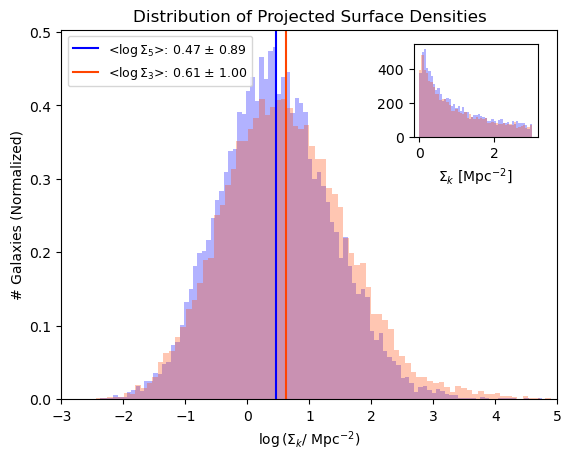

In [1311]:
plt.figure()
fig,ax=plt.subplots()
im1 = ax.hist(np.log10(all_5NN),bins=100,alpha=0.3,color='blue',density=True) #,label=r'$\Sigma_5$ 2D Densities')
im2 = ax.hist(np.log10(all_3NN),bins=100,alpha=0.3,color='orangered',density=True) #,label=r'$\Sigma_3$ 2D Densities')

im3=ax.axvline(np.mean(np.log10(all_5NN)),color='blue',label=fr'<$\log\Sigma_5$>: {np.mean(np.log10(all_5NN)):.2f}'\
              +fr' $\pm$ {np.std(np.log10(all_5NN)):.2f}')
im4=ax.axvline(np.mean(np.log10(all_3NN)),color='orangered',label=f'<$\log\Sigma_3$>: {np.mean(np.log10(all_3NN)):.2f}'\
              +fr' $\pm$ {np.std(np.log10(all_3NN)):.2f}')

ins = ax.inset_axes([0.71,0.71,0.25,0.25])
ins.hist(all_5NN[all_5NN<3.],bins=50,alpha=0.3,color='blue')
ins.hist(all_3NN[all_3NN<3.],bins=50,alpha=0.3,color='orangered')

ins.set_xlabel(r'$\Sigma_k$ [Mpc$^{-2}$]')

plt.title(r'Distribution of Projected Surface Densities')
plt.xlabel(r'$\log$($\Sigma_k$/ Mpc$^{-2})$')
plt.ylabel('# Galaxies (Normalized)')
plt.legend(loc='upper left',fontsize=9)

plt.xlim(-3,5)

plt.show()

### Comparing k=5 values to Castignani+2022 -- VFS galaxies only

In [14]:
phot_r=Table.read(homedir+'/Desktop/v2-20220820/vf_v2_r_photometry.fits')
M_r_flag = (phot_r['M_r']<=-15.7)
env=Table.read(homedir+'/Desktop/v2-20220820/vf_v2_environment.fits')[M_r_flag]
clus_flag = env['cluster_member']

In [43]:
%run kNN_local_density.py -vr_limit 500 -k 5 -vfs

-vr_limit [int in km/s; default is 500] -radius_limit [int in Mpc; default is 100 (no radius bounds)] -k [int; default is 5 (for fifth nearest neighbor)] -vfs [if included, will use VFS catalog and SGY bounds (from Castignani+22) in place of the vr_limit slice; otherwise, will default to NED-LVS catalog] -write [will write array output to nedlvs_parent table]
Using vr_limit = 500 km/s
Using radius_limit = 100 Mpc --> no limit!
Using k = 5
Applying absolute r-band magnitude completeness flag (M_r<=-15.7) to VFS...
Using SG Coordinates from VFS catalogs...
# galaxies in input table without kSigma: 2
Execution Time: 0.01 minute(s)


<Figure size 640x480 with 0 Axes>

In [44]:
vf_kNN = env['n5th_2D']   #5NN values for VFS galaxies from Gianluca's paper
my_kNN = all_kNN   #5NN values for VFS galaxies calculated using my algorithm

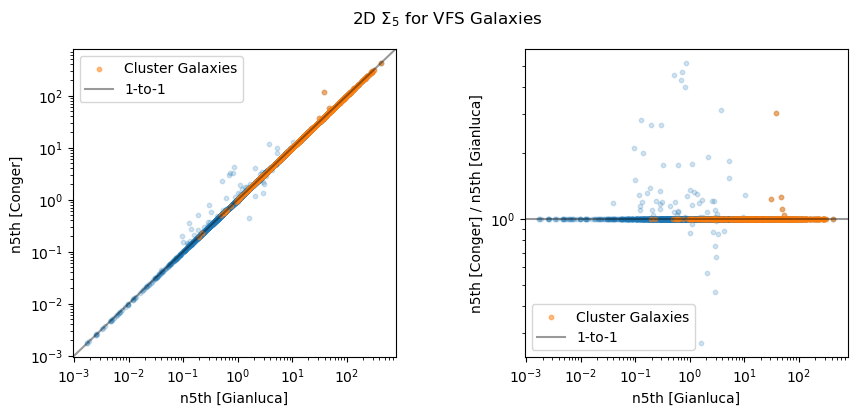

Mean ratio: 1.01 +/- 0.16
Median ratio: 1.00

Mean ratio: 1.01 +/- 0.17
Median ratio: 1.00

Fraction with ratio > 1.2: 0.01


In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.4)
plt.subplot(1,2,1)
plt.scatter(vf_kNN,my_kNN,alpha=0.2,s=10)
plt.scatter(vf_kNN[clus_flag],my_kNN[clus_flag],alpha=0.5,s=10,label='Cluster Galaxies')
plt.axline([0,0],slope=1,color='black',alpha=0.4,label='1-to-1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n5th [Gianluca]')
plt.ylabel('n5th [Conger]')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(vf_kNN,my_kNN/vf_kNN,alpha=0.2,s=10)
plt.scatter(vf_kNN[clus_flag],my_kNN[clus_flag]/vf_kNN[clus_flag],alpha=0.5,s=10,label='Cluster Galaxies')
plt.axhline(1,color='black',alpha=0.4,label='1-to-1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n5th [Gianluca]')
plt.ylabel('n5th [Conger] / n5th [Gianluca]')
plt.legend()

plt.suptitle(r'2D $\Sigma_{5}$ for VFS Galaxies')
plt.show()

print(f'Mean ratio: {np.mean(my_kNN/vf_kNN):.2f} +/- {np.std(my_kNN/vf_kNN):.2f}')
print(f'Median ratio: {np.median(my_kNN/vf_kNN):.2f}')
print()
print(f'Mean ratio: {np.mean(my_kNN[~clus_flag]/vf_kNN[~clus_flag]):.2f} +/- {np.std(my_kNN[~clus_flag]/vf_kNN[~clus_flag]):.2f}')
print(f'Median ratio: {np.median(my_kNN[~clus_flag]/vf_kNN[~clus_flag]):.2f}')
print()
print(f'Fraction with ratio > 1.2: {len((my_kNN/vf_kNN)[(my_kNN/vf_kNN)>1.2])/len(my_kNN):.2f}')

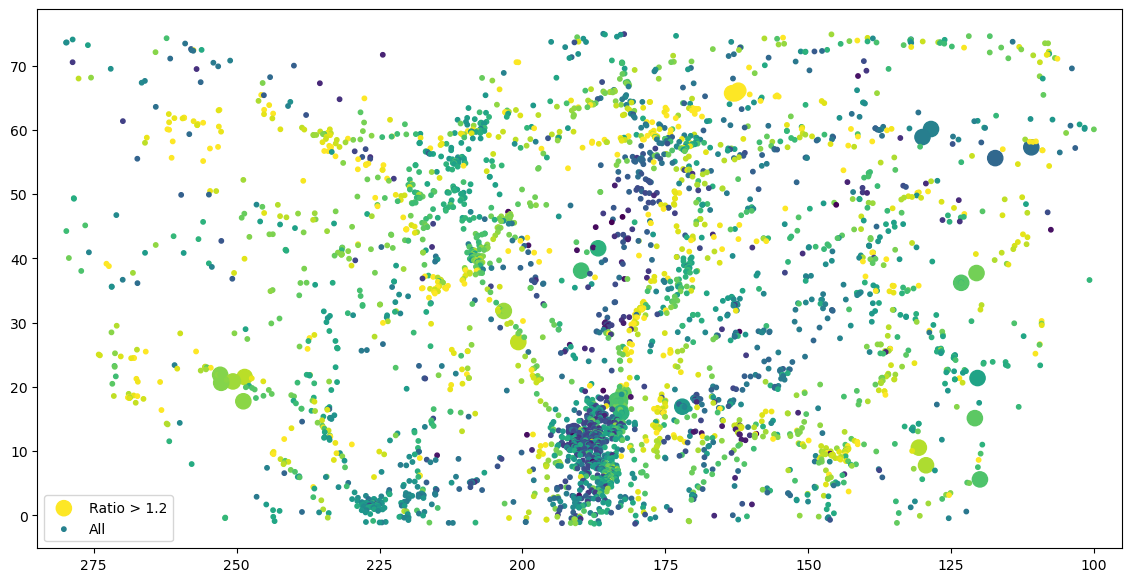

In [46]:
#outlier flag
outlier_flag = ((my_kNN/vf_kNN)>1.2)

plt.figure(figsize=(14,7))
plt.scatter(cat['RA'][outlier_flag],cat['DEC'][outlier_flag],s=120,alpha=1,c=env['Vcosmic'][outlier_flag],
           label='Ratio > 1.2',vmin=500,vmax=3500)
plt.scatter(cat['RA'],cat['DEC'],s=10,alpha=1,c=env['Vcosmic'],label='All',vmin=500,vmax=3500)
plt.xlim(np.max(cat['RA'])+5,np.min(cat['RA'])-5)
plt.legend()

In [891]:
# for VFS redshifts (for my algorithm), I converted Vcosmic using v=cz. 
# maybe I try using Vmodel instead -- doing now
# results of Vmodel: even more scatter. not the solution.

# another discrepancy -- Gianluca uses supergalactic coordinates
# "The 2D density is evaluated by including galaxies within a ΔSGY = 5.6 h^{−1} Mpc width, which 
# corresponds to the 2σ statistical uncertainty along the line of sight at the distance of Virgo."
# Using this, along with using SGX, SGZ for r_5, yields...
# marginally less scatter, but there is still some sort of systematic offset occurring.
# okay. could be the offset is due to the units of SGX, SGY, and SGZ in the catalog being Mpc/h. 
# I am now multiplying all SG coordinates by 0.74. this will hopefully help.
    # (lines 142-3, 226-8)
    # still a massive offset. WHY?!
# alright. the h is very likely not the problem - it follows the SGX, SGY, SGZ values into the 5NN value
# (which has units of h^2 / Mpc^2). I removed it from the calculations. 

In [907]:
# new day. new thoughts.
# possible other causes of discrepancy:
    # r-band absolute magnitude cut -- Gianluca applied one, I did not
        # M_r <= -15.7
    # Gianluca did not remove central galaxy from 5NN calculation, meaning that it was instead a 4NN calculation
        # changed [4] to [3] in line 166 !
    # perhaps the offset is, in fact, due to the h constant. units are reported as [(h^{-1} Mpc)^{-2}] 
    # in his code, even though SG coordinates are also h^{-1} and documentation says h^i/Mpc^2 as well as 
    # h^2^/Mpc^2^...

# YES. using [3] did, indeed, help a bit with a bulk of the lower-end scatter (e.g., where my values were much
# higher than Gianluca's...now, they are equivalent because dist[3] < dist[4])
# note that there are very few galaxies for which this change is nontrivial
# now applying M_r <= -15.7 flag
# even less scatter! Median ratio is 1.11. 

# pending additional suggestions, I am satisfied with this result.

In [909]:
# but alas, Greg is not satisfied. We now think that in addition to the M_r < -15.6 completeness cut, 
# Gianluca may have applied any further flags to the VFS before calculating n5_2D.
# Having fewer galaxies with which to calculate n5_2D could be a reason why his densities are 
# systematically lower than mine (indeed, for 45% of the galaxies the ratio of my densities to his is > 1.2).



In [48]:
#NEXT STEP. disregard Gianluca's VFS values. 
# instead -- create a mock catalog of galaxies with "known 5NN" density values.
# how to do so...
# make a "clumpy" spread of galaxies. x-y values will correspond to SGX-SGZ. or RA-DEC.
# (what about SGY? ignore for now, I suppose)
# (overlay a few "random" distributions of points, or "Gaussian distributions")

#NVM. ALL SET. :-)

### Comparing k=5 redshift slices $\pm$ 500 km/s and $\pm$ 1000 km/s

In [1333]:
%run kNN_local_density.py -vr_limit 500 -k 5

-vr_limit [int in km/s; default is 500] -radius_limit [int in Mpc; default is 100 (no radius bounds)] -k [int; default is 5 (for fifth nearest neighbor)] -vfs [if included, will use VFS catalog and SGY bounds (from Castignani+22) in place of the vr_limit slice; otherwise, will default to WISESize catalog]
Using vr_limit = 500 km/s
Using radius_limit = 100 Mpc --> no limit!
Using k = 5
Number of Galaxies without kSigma: 1807
Execution Time: 9.4 minute(s)


In [1334]:
all_5NN_500 = all_kNN

In [1335]:
%run kNN_local_density.py -vr_limit 1000 -k 5

-vr_limit [int in km/s; default is 500] -radius_limit [int in Mpc; default is 100 (no radius bounds)] -k [int; default is 5 (for fifth nearest neighbor)] -vfs [if included, will use VFS catalog and SGY bounds (from Castignani+22) in place of the vr_limit slice; otherwise, will default to WISESize catalog]
Using vr_limit = 1000 km/s
Using radius_limit = 100 Mpc --> no limit!
Using k = 5
Number of Galaxies without kSigma: 1436
Execution Time: 6.7 minute(s)


In [1336]:
all_5NN_1000 = all_kNN

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_30471/3813361651.py:2: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(all_5NN_500),np.log10(all_5NN_1000),s=10,alpha=0.04)


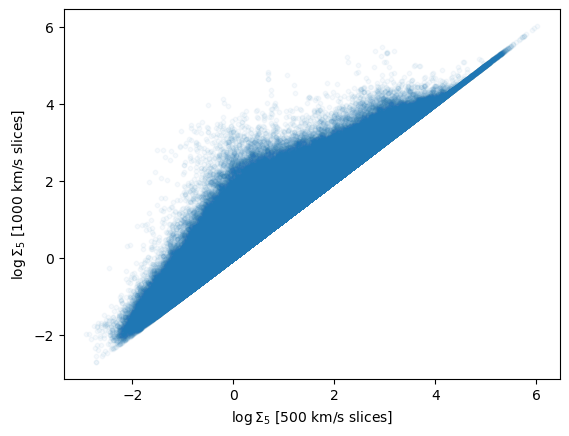

In [1344]:
plt.figure()
plt.scatter(np.log10(all_5NN_500),np.log10(all_5NN_1000),s=10,alpha=0.04)

plt.xlabel(r'$\log{\Sigma_5}$ [500 km/s slices]')
plt.ylabel(r'$\log{\Sigma_5}$ [1000 km/s slices]')
plt.show()